# Imports

In [26]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

## import image

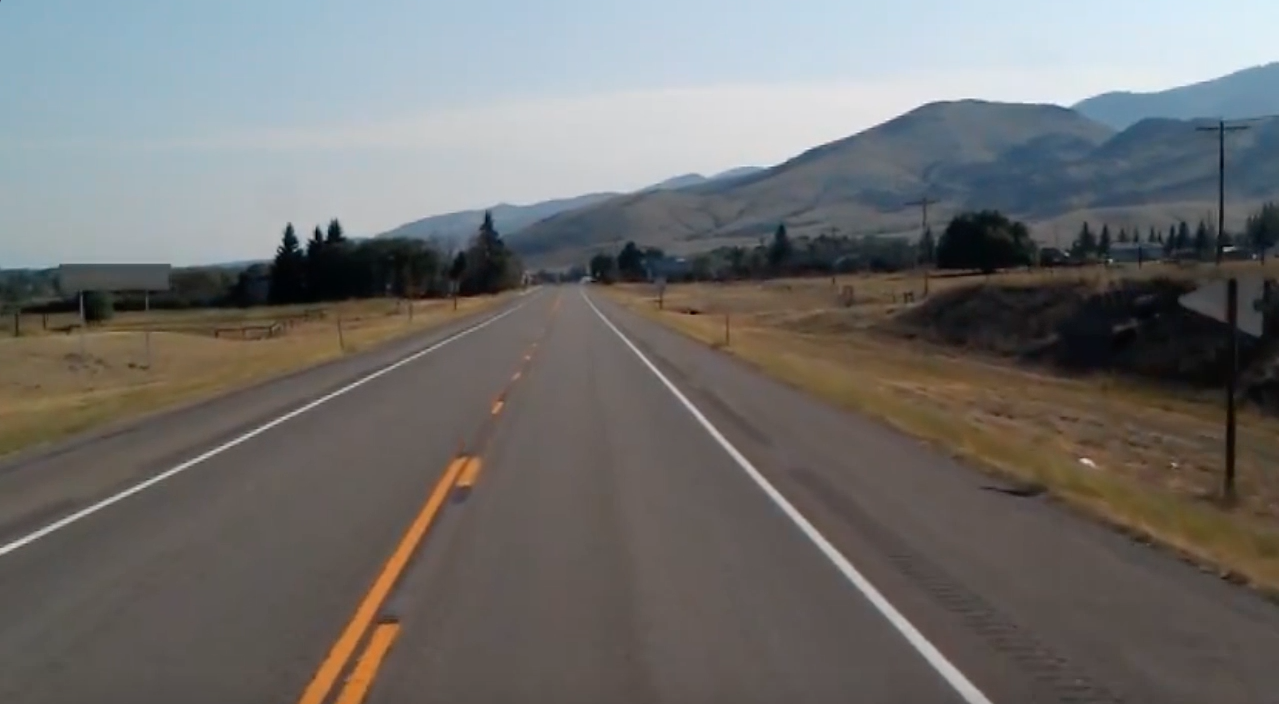

In [27]:
image = cv2.imread('test_image.jpg')
cv2_imshow(image)

# Conversion

In [28]:
# Convert to grayscale
lanelines_image = np.copy(image)
gray_conversion= cv2.cvtColor(lanelines_image, cv2.COLOR_RGB2GRAY)

# Smoothing
blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5),0)
# Canny Edge detection
canny_conversion = cv2.Canny(blur_conversion, 50,155)

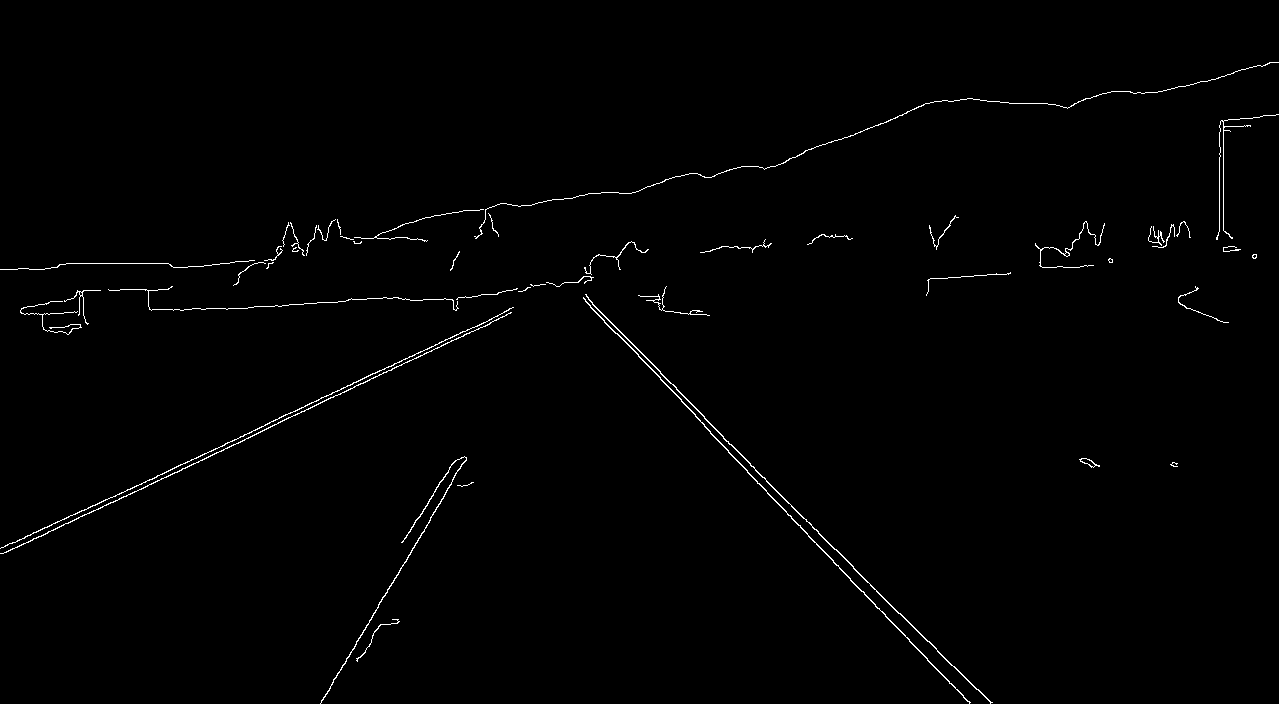

In [29]:
cv2_imshow(canny_conversion)

# Masking

In [32]:
def canny_edge(image):
         gray_conversion= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
         blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5),0)
         canny_conversion = cv2.Canny(blur_conversion, 50,150)
         return canny_conversion

In [36]:
def reg_of_interest(image):
         image_height = image.shape[0]
         polygons = np.array([[(200, image_height), (1100, image_height), (551, 250)]])
         image_mask = np.zeros_like(image)
         cv2.fillPoly(image_mask, polygons, 255)
         masking_image = cv2.bitwise_and(image,image_mask)
         return masking_image

In [40]:
image = cv2.imread('test_image.jpg')
lanelines_image = np.copy(image)
canny_conversion = canny_edge(lanelines_image)
cropped_image = reg_of_interest(canny_conversion)

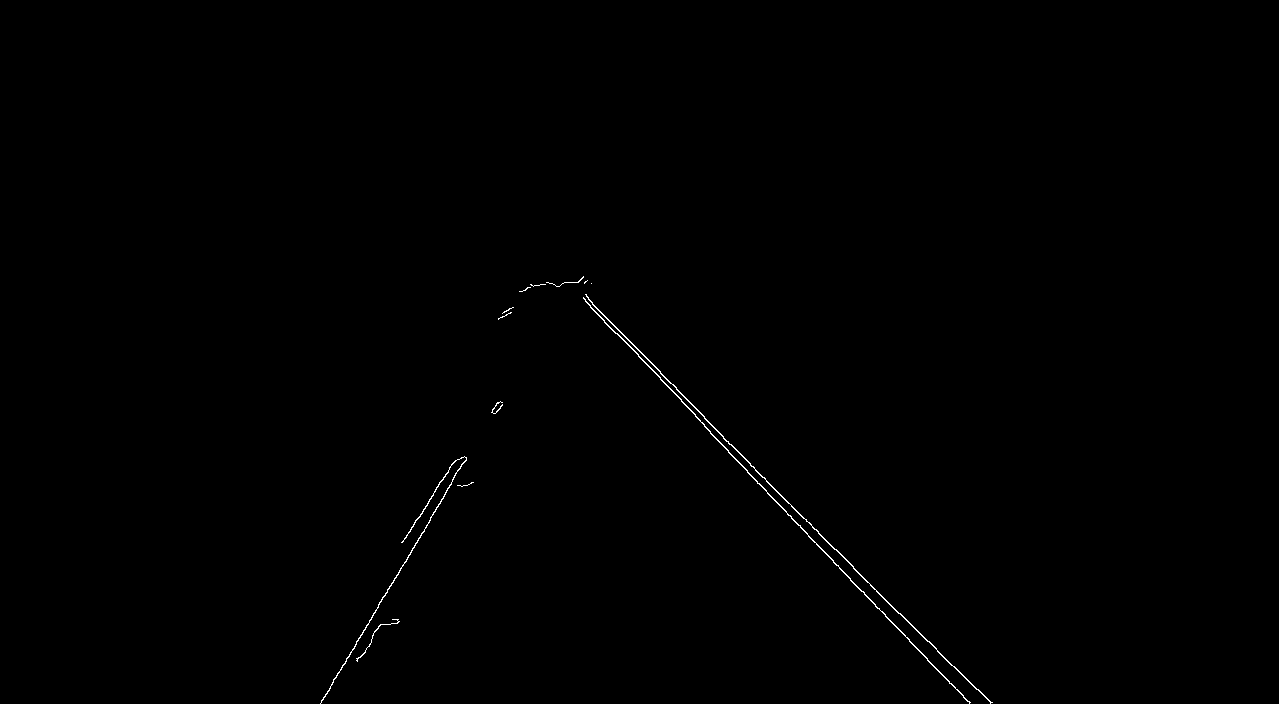

In [41]:
cv2_imshow(cropped_image)

## hough transform

In [42]:
def show_lines(image, lines):
            lines_image = np.zeros_like(image)
            if lines is not None:
                for line in lines:
                    X1, Y1, X2, Y2 = line.reshape(4)
                    cv2.line(lines_image, (X1, Y1), (X2, Y2), (255,0,0), 10)
            return lines_image

In [43]:
image = cv2.imread('test_image.jpg')
lanelines_image = np.copy(image)
canny_conversion = canny_edge(lanelines_image)
cropped_image = reg_of_interest(canny_conversion)

In [44]:
lane_lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength= 40, maxLineGap=5)
linelines_image = show_lines(lanelines_image, lane_lines)

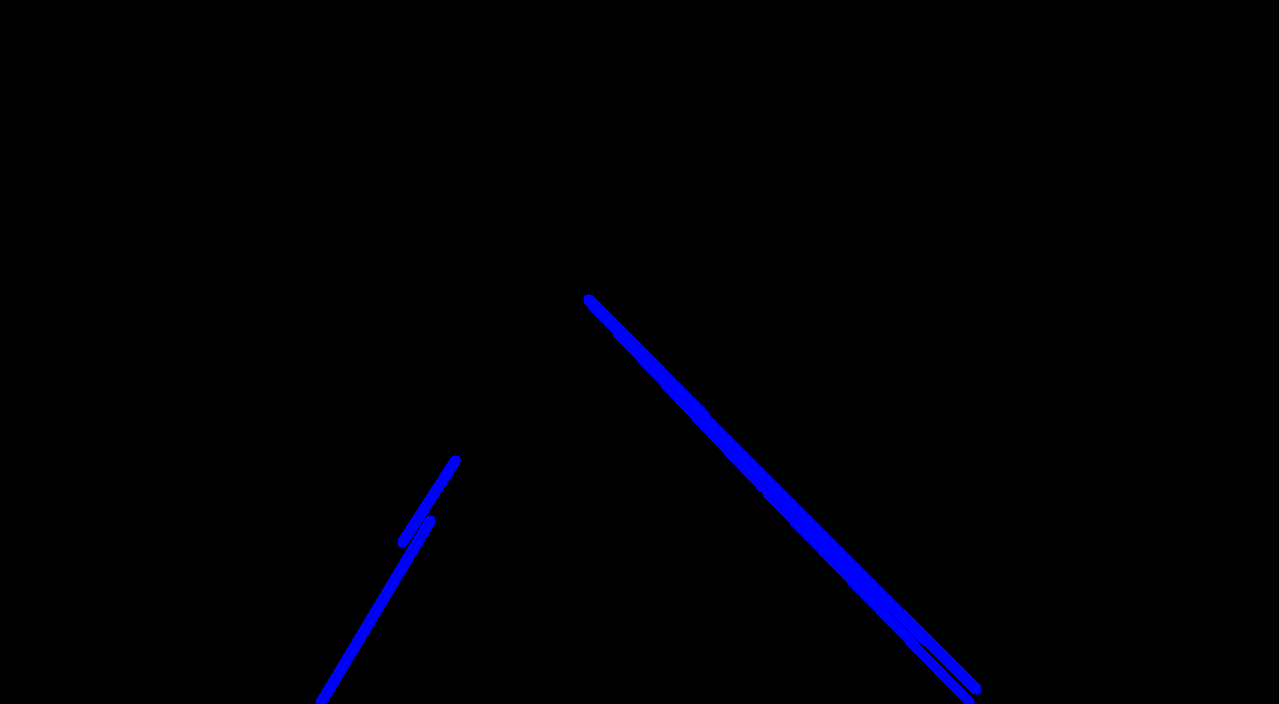

In [45]:
cv2_imshow(linelines_image)

In [46]:
combine_image = cv2.addWeighted(lanelines_image, 0.8, linelines_image, 1, 1)

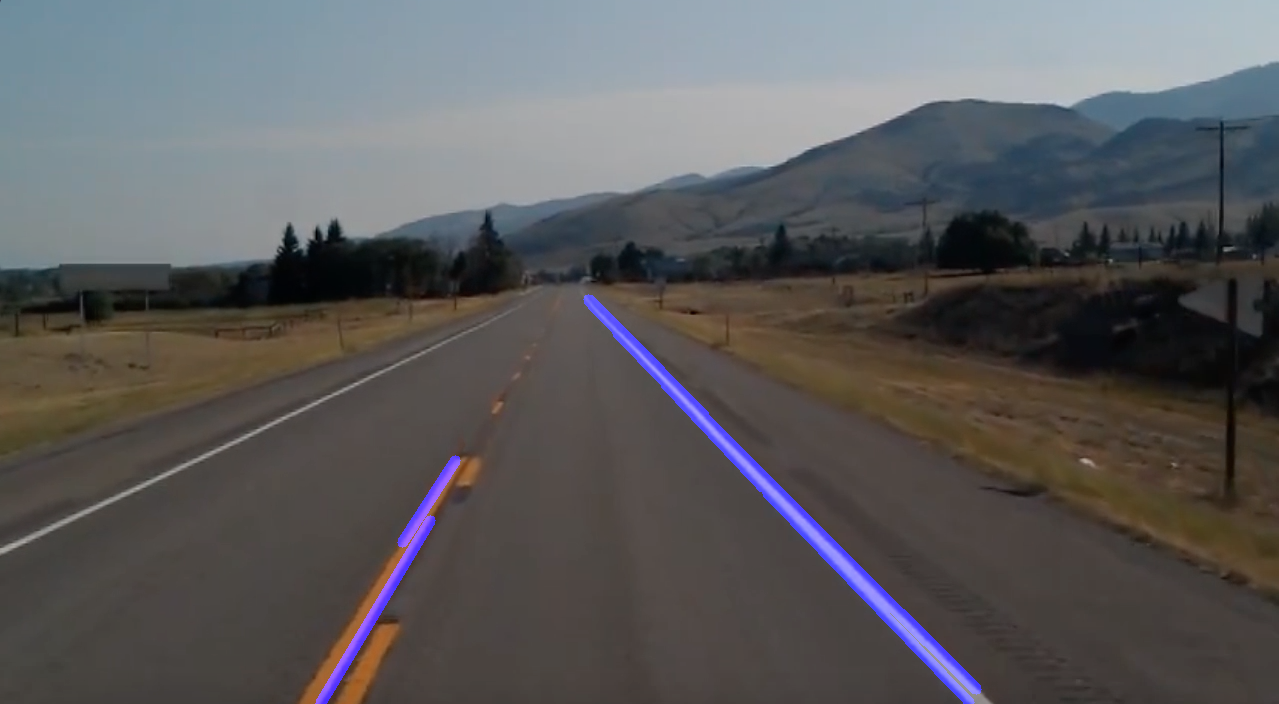

In [47]:
cv2_imshow(combine_image)

# Optimization

In [48]:
def make_coordinates(image, line_parameters):
          try:
            slope, intercept = line_parameters
          except TypeError:
            slope, intercept = 0.001,0
          #slope, intercept = line_parameters
          y1 = image.shape[0]
          y2 = int(y1*(3/5))
          x1 = int((y1- intercept)/slope)
          x2 = int((y2 - intercept)/slope)
          return np.array([x1, y1, x2, y2])

In [49]:
def average_slope_intercept(image, lines):
          left_fit = []
          right_fit = []
          for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            parameter = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameter[0]
            intercept = parameter[1]
            if slope < 0:
              left_fit.append((slope, intercept))
            else:
              right_fit.append((slope, intercept))
          left_fit_average =np.average(left_fit, axis=0)
          right_fit_average = np.average(right_fit, axis =0)
          left_line =make_coordinates(image, left_fit_average)
          right_line = make_coordinates(image, right_fit_average)
  
          return np.array([left_line, right_line])

In [50]:
image = cv2.imread('test_image.jpg')
lanelines_image = np.copy(image)
canny_conversion = canny_edge(lanelines_image)
cropped_image = reg_of_interest(canny_conversion)
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength= 40, maxLineGap=5)
averaged_lines = average_slope_intercept(lanelines_image, lines)
line_image = show_lines(lanelines_image, averaged_lines)
combine_image = cv2.addWeighted(lanelines_image, 0.8, line_image, 1, 1)

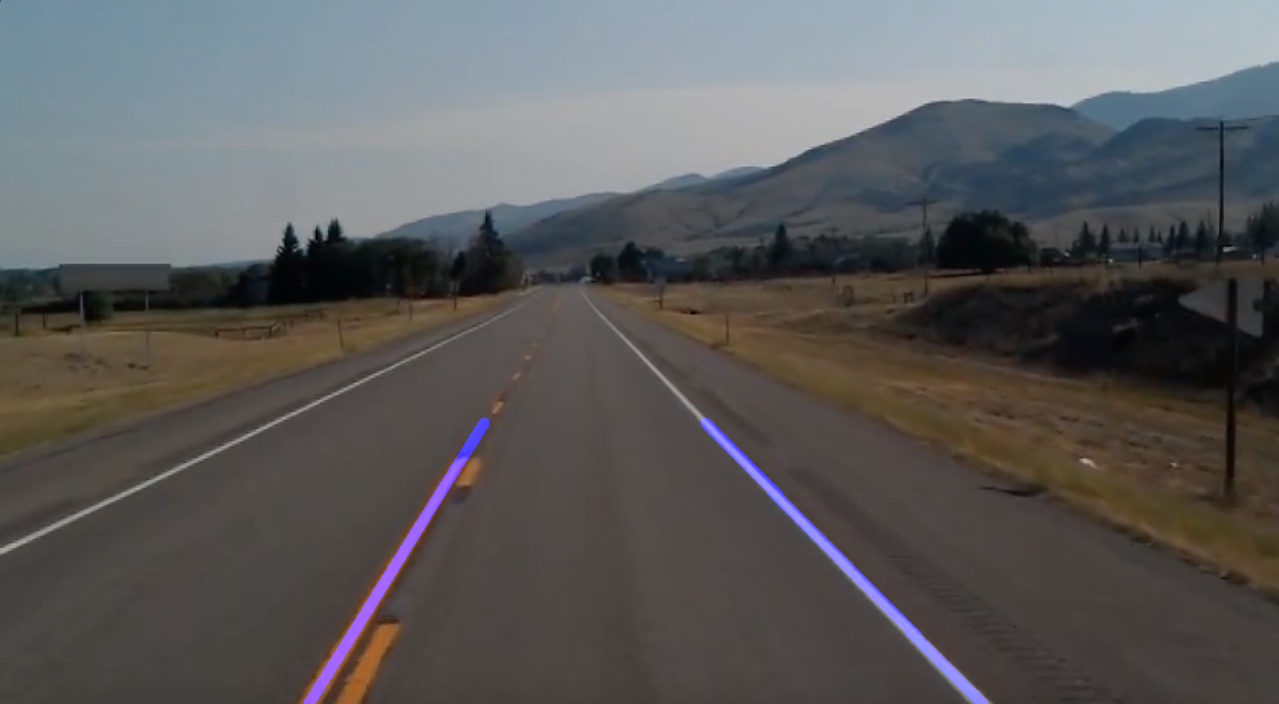

In [51]:
cv2_imshow(combine_image)

# Detect in video

In [52]:
cap = cv2.VideoCapture("test2.mp4")

In [53]:
while(cap.isOpened()):
            _, frame = cap.read()
            canny_image = canny_edge(frame)
            cropped_canny = reg_of_interest(canny_image)
            lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
            averaged_lines = average_slope_intercept(frame, lines)
            line_image = show_lines(frame, averaged_lines)
            combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
            cv2.imshow("result", combo_image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
cap.release()